## Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import RepeatVector, TimeDistributed, LSTM, Input

import keras 
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv1D,ConvLSTM2D
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import MaxPooling1D
from keras.layers import concatenate
from keras.models import Model

## Read Data

In [12]:
X_train = pd.read_csv('../data/FS2_test.csv')
X_test = pd.read_csv('../data/FS2_test.csv')
sample = pd.read_csv('../data/submission/sample_submission.csv')

In [13]:
X_train

,id,day_of_week,base_hour,lane_count,road_rating,maximum_speed_limit,road_type,start_latitude,start_longitude,start_turn_restricted,...,coor_label,base_month,base_day,bearing,rn_target,coor_target,hour_std,coor_std,main_hour_edge,main_hour_dow
0,TRAIN_0000000,1,0.807704,-1.321033,106,60.0,3,0.510128,1.219128,0,...,0,-1.049531,0.437966,-0.820236,1.135277,0.829536,1.362228,-0.219310,0.640882,-0.366799
1,TRAIN_0000001,1,1.318952,0.168554,103,60.0,0,1.161774,0.109643,1,...,1,0.952806,1.190126,-0.252679,0.012531,-0.934496,-0.713705,0.357531,0.374300,-0.366799
2,TRAIN_0000010,1,-0.015124,-1.321033,103,60.0,0,0.434431,-0.204928,0,...,10,-1.049531,0.437966,0.253633,0.095295,0.561863,0.196601,-1.278157,0.374300,-0.366799
3,TRAIN_0000011,4,-1.499524,-1.321033,107,50.0,0,-1.145319,0.449015,0,...,11,0.952806,0.583729,-0.782769,-1.505531,-0.900928,-0.786130,-0.556979,0.374300,0.846410
4,TRAIN_0000016,0,1.443150,0.168554,107,50.0,0,1.030129,-0.216676,0,...,16,0.952806,-1.954304,-0.807262,-1.794044,-0.806236,-0.523751,0.874309,-0.917207,0.846410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524069,TRAIN_4701164,0,-0.310084,1.419321,103,70.0,0,0.898483,0.245392,0,...,52,0.952806,-1.408032,1.502814,0.012531,-0.196164,0.447842,-0.143478,0.374300,0.846410
524070,TRAIN_4701178,4,0.542018,-1.321033,106,60.0,3,-0.753672,-0.225813,0,...,-164,0.952806,1.668062,-0.926797,1.448100,1.034028,0.444129,-1.114579,0.374300,0.846410
524071,TRAIN_4701179,1,0.807704,-1.321033,106,30.0,0,-0.194178,-2.183727,0,...,-454,-1.049531,1.506635,1.858116,0.460587,-0.532789,1.362228,-1.519579,1.727413,-0.366799
524072,TRAIN_4701181,3,-0.781254,1.419321,103,70.0,0,1.046584,0.203623,1,...,773,-1.049531,0.015610,-0.322983,0.012531,-1.718960,-0.081547,0.676123,0.640882,-1.429230


In [14]:
y_train = X_train['target']
X_train.drop(columns = ["id","target"], inplace=True)
X_test = X_test.drop(columns = ["id"])
X_test.head()

,day_of_week,base_hour,lane_count,road_rating,maximum_speed_limit,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,...,coor_label,base_month,base_day,bearing,rn_target,coor_target,hour_std,coor_std,main_hour_edge,main_hour_dow
0,1,0.807704,1.419321,107,70.0,0,1.151901,0.211455,0,1.161799,...,-352,3.271892,0.731880,0.646048,-0.409930,-0.204939,1.362228,1.246122,2.560013,-1.812128
1,6,0.127860,0.168554,103,70.0,3,-1.049875,-0.745313,0,-1.053189,...,279,3.271892,-1.308832,-0.846390,0.171659,0.649752,0.323116,-0.419093,1.180404,-1.812060
2,0,-1.499524,-1.321033,103,60.0,0,-1.046584,-0.328930,0,-1.043315,...,332,3.271892,-1.677982,-0.736243,0.567949,1.314444,-0.786130,-0.120684,-1.640376,-1.812128
3,1,1.566060,1.419321,103,70.0,0,0.918230,0.248002,0,0.898502,...,-39,3.271892,-0.252831,-1.643479,0.012531,-0.196164,-0.879366,-0.143478,0.640882,-1.812128
4,2,0.807704,1.419321,106,70.0,0,1.168357,0.443794,0,1.128887,...,724,3.271892,-1.205515,1.254552,1.058966,0.544772,1.362228,-0.640810,2.560013,-1.812054


In [7]:
# model input data size
print('X_train.shape:', X_train.shape, 'X_test.shape', X_test.shape)
print('feature:', X_train.columns)
print('X_train.shape:', X_train.shape)

X_train.shape: (524074, 25) X_test.shape (291241, 25)
feature: Index(['day_of_week', 'base_hour', 'lane_count', 'road_rating',
       'maximum_speed_limit', 'road_type', 'start_latitude', 'start_longitude',
       'start_turn_restricted', 'end_latitude', 'end_longitude',
       'end_turn_restricted', 'start_node_label', 'end_node_label',
       'edge_label', 'coor_label', 'base_month', 'base_day', 'bearing',
       'rn_target', 'coor_target', 'hour_std', 'coor_std', 'main_hour_edge',
       'main_hour_dow'],
      dtype='object')
X_train.shape: (524074, 25)


## ConvLSTM
- 특정 도로링크의 속도는 이웃하는 도로링크들의 속도에 종속된다. 또한, 해당 도로링크의 이전 시간의 속도들에 의해 현재
속도가 종속된다. 
- 이런 공간적 특징과 시간적 특징을 모두 고려하기 위해 RCNN 기반의 속도 분류기법을 제안하였다. 

In [23]:
sample_size = X_train.shape[0] # number of samples in train set
time_steps  = X_train.shape[1] # number of features in train set
input_dimension = 1               # each feature is represented by 1 number


train_data_reshaped = X_train.reshape(sample_size,time_steps,input_dimension)
test_data_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1],1)


print("After reshape train data set shape:\n", train_data_reshaped.shape)
print("1 Sample shape:\n",train_data_reshaped[0].shape)
print("An example sample:\n", train_data_reshaped[0])

After reshape train data set shape:
 (471666, 25, 1)
1 Sample shape:
 (25, 1)
An example sample:
 [[ 3.00000000e+00]
 [ 1.06639559e+00]
 [-1.32103256e+00]
 [ 1.07000000e+02]
 [ 5.00000000e+01]
 [ 0.00000000e+00]
 [-6.71393657e-01]
 [-1.52717308e+00]
 [ 0.00000000e+00]
 [-6.45078221e-01]
 [-1.51832872e+00]
 [ 0.00000000e+00]
 [ 3.96000000e+02]
 [ 3.96000000e+02]
 [ 5.86000000e+02]
 [-6.47000000e+02]
 [-1.04953140e+00]
 [ 1.56097008e-02]
 [ 2.39944732e-01]
 [ 1.34690177e+00]
 [-4.18072041e-01]
 [ 1.18332076e+00]
 [-1.99858369e+00]
 [ 1.72741336e+00]
 [-1.42922970e+00]]


In [24]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_data_reshaped, y_train, test_size = 0.1, random_state = 42)

X_train.shape

(424499, 25, 1)

In [38]:
def convLSTM_model():
    # Define the NN architecture
    n_timesteps = X_train.shape[1] #25
    n_features  = X_train.shape[2] #1 
    model = keras.Sequential(name="convLSTM_model")
    model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=7, activation='relu', name="Conv1D_1"))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.BatchNormalization(scale=False))
    model.add(LSTM(units= 12, activation='relu', return_sequences=True))
    model.add(LSTM(units= 6, activation='relu', return_sequences=True))
    # model.add(RepeatVector(n_timesteps))
    model.add(LSTM(units= 6, activation='relu', return_sequences=True))
    model.add(LSTM(units= 12, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))


    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',optimizer=optimizer,metrics=['mae'])
    return model

convLSTM_model = convLSTM_model()
convLSTM_model.summary()
        # fname = f"{folder}/loop_submission_{t.month:02}{t.day:02}_{SEED:05}.csv"
        # submission.to_csv(os.path.abspath("../submissions") + '/' + fname, index=False) 

Model: "convLSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 19, 64)            512       
                                                                 
 dropout_7 (Dropout)         (None, 19, 64)            0         
                                                                 
 batch_normalization_4 (Batc  (None, 19, 64)           192       
 hNormalization)                                                 
                                                                 
 lstm_14 (LSTM)              (None, 19, 12)            3696      
                                                                 
 lstm_15 (LSTM)              (None, 19, 6)             456       
                                                                 
 lstm_16 (LSTM)              (None, 19, 6)             312       
                                                    

In [ ]:
# Store training stats
history = convLSTM_model.fit(X_train, y_train,  validation_data=(X_valid, y_valid),epochs=10,verbose=1)

Epoch 1/10
13266/13266 [==============================] - 343s 25ms/step - loss: 1555.1694 - mae: 13.7867 - val_loss: 242.5054 - val_mae: 12.8834
Epoch 2/10
 1788/13266 [===>..........................] - ETA: 4:42 - loss: 245.0871 - mae: 13.0073

## Conv1d - Successed

In [27]:
def build_conv1D_model():
    n_timesteps = X_train.shape[1] #13
    n_features  = X_train.shape[2] #1 
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=7, activation='relu', name="Conv1D_1"))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv1D_2"))
  
    model.add(keras.layers.Conv1D(filters=16, kernel_size=2, activation='relu', name="Conv1D_3"))
  
    model.add(keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(32, activation='relu', name="Dense_1"))
    model.add(keras.layers.Dense(n_features, name="Dense_2"))


    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',optimizer=optimizer,metrics=['mae'])
    return model

model_conv1D = build_conv1D_model()
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 19, 64)            512       
                                                                 
 dropout (Dropout)           (None, 19, 64)            0         
                                                                 
 Conv1D_2 (Conv1D)           (None, 17, 32)            6176      
                                                                 
 Conv1D_3 (Conv1D)           (None, 16, 16)            1040      
                                                                 
 MaxPooling1D (MaxPooling1D)  (None, 8, 16)            0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 Dense_1 (Dense)             (None, 32)               

In [28]:
# Store training stats
history = model_conv1D.fit(X_train, y_train,  validation_data=(X_valid, y_valid),epochs=10,verbose=1)

Epoch 1/10
13266/13266 [==============================] - 46s 3ms/step - loss: 95.0460 - mae: 7.0970 - val_loss: 47.1866 - val_mae: 5.4028
Epoch 2/10
13266/13266 [==============================] - 46s 3ms/step - loss: 35.0306 - mae: 4.4443 - val_loss: 30.2088 - val_mae: 4.0865
Epoch 3/10
13266/13266 [==============================] - 46s 3ms/step - loss: 33.2155 - mae: 4.3001 - val_loss: 29.4126 - val_mae: 3.9805
Epoch 4/10
13266/13266 [==============================] - 45s 3ms/step - loss: 32.2414 - mae: 4.2166 - val_loss: 32.4474 - val_mae: 4.3391
Epoch 5/10
13266/13266 [==============================] - 45s 3ms/step - loss: 31.7891 - mae: 4.1726 - val_loss: 42.3519 - val_mae: 5.0597
Epoch 6/10
13266/13266 [==============================] - 45s 3ms/step - loss: 31.3857 - mae: 4.1376 - val_loss: 41.5523 - val_mae: 4.9979
Epoch 7/10
13266/13266 [==============================] - 45s 3ms/step - loss: 31.1028 - mae: 4.1162 - val_loss: 38.8309 - val_mae: 4.7901
Epoch 8/10
13266/13266 [===

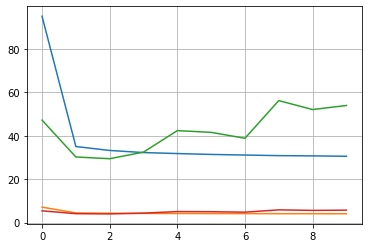

In [29]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)

In [30]:
test_predictions = model_conv1D.predict(X_test).flatten()
# Make submissions
submission = pd.DataFrame({
    "ID": sample["id"], 
    "STATUS": test_predictions
})
submission

9102/9102 [==============================] - 14s 2ms/step


,ID,STATUS
0,TEST_000000,26.649132
1,TEST_000001,40.381306
2,TEST_000002,51.621101
3,TEST_000003,37.268524
4,TEST_000004,43.282120
...,...,...
291236,TEST_291236,40.295670
291237,TEST_291237,46.341553
291238,TEST_291238,23.018744
291239,TEST_291239,24.391609


## RNN

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 25, 128)           16640     
                                                                 
 dropout_1 (Dropout)         (None, 25, 128)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 25, 256)           98560     
                                                                 
 dropout_2 (Dropout)         (None, 25, 256)           0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 25, 128)           49280     
                                                                 
 dropout_3 (Dropout)         (None, 25, 128)           0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 25, 64)            1

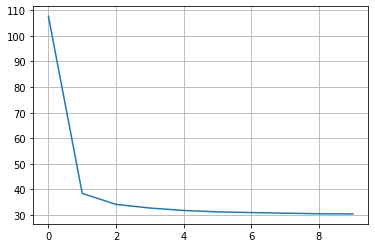

In [31]:
# RNN
model = Sequential()
#return seqeunce : 계산된 파라미터를 다시 받아올것인가?
model.add(SimpleRNN(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(0.5)) 
model.add(SimpleRNN(256, return_sequences=True, activation="relu"))
model.add(Dropout(0.5)) 
model.add(SimpleRNN(128, return_sequences=True, activation="relu"))
model.add(Dropout(0.5)) 
model.add(SimpleRNN(64, return_sequences=True, activation="relu"))
model.add(Dropout(0.5)) 
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, y_train, 
                      batch_size=100, epochs=10,
                      verbose=0)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

In [32]:
test_predictions = model_conv1D.predict(X_test).flatten()
# Make submissions
submission = pd.DataFrame({
    "ID": sample["id"], 
    "STATUS": test_predictions
})
submission

9102/9102 [==============================] - 14s 2ms/step


,ID,STATUS
0,TEST_000000,26.649132
1,TEST_000001,40.381306
2,TEST_000002,51.621101
3,TEST_000003,37.268524
4,TEST_000004,43.282120
...,...,...
291236,TEST_291236,40.295670
291237,TEST_291237,46.341553
291238,TEST_291238,23.018744
291239,TEST_291239,24.391609


In [ ]:
# 세 모델 모두 성능이 좋지 않아 사용하지 않는다.